<a href="https://colab.research.google.com/github/newstage75/ML_study/blob/master/%E6%9C%80%E7%9F%ADPytorch/%EF%BC%98%E7%AB%A0%EF%BC%88%E9%9A%A0%E3%82%8C%EF%BC%92%E5%B1%A4%EF%BC%89MNIST%E3%82%92%E4%BD%BF%E3%81%A3%E3%81%9F%E6%95%B0%E5%AD%97%E8%AA%8D%E8%AD%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#８章（隠れ２層）MNISTを使った数字認識

ランタイプの変更からGPUに変更している。

In [1]:
# 必要ライブラリの導入

!pip install japanize_matplotlib | tail -n 1
!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1

In [2]:
# 必要ライブラリのインポート

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from IPython.display import display

In [3]:
# torch関連ライブラリのインポート

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot

In [4]:
# warning表示off
import warnings
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)

# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True

# numpyの表示桁数設定
np.set_printoptions(suppress=True, precision=5)

###GPU利用

####GPU利用のルール

1.テンソル変数はデータがCPU/GPU上のどちらにあるのかを属性として持っている

2.CPUとGPU間のデータはto関数で転送する

3.2つの変数が両方ともGPU上にある場合、演算はGPUで行われる

4.変数の片方がCPU、もう一方がGPUの場合はエラーになる。

In [5]:
#デバイスの割り当て
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
#データ準備1(データセットによる読み込み)

#ライブラリインポート
import torchvision.datasets as datasets

# ダウンロード先ディレクトリ名
data_root = './data'

train_set0 = datasets.MNIST(
    #元データダウンロード先の指定
    root = data_root,
    #訓練データか検証データか
    train = True,
    #元データがない場合にダウンロードするか
    download = True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [7]:
#ダウンロードしたの確認

!ls -lR ./data/MNIST

./data/MNIST:
total 4
drwxr-xr-x 2 root root 4096 May 23 12:09 raw

./data/MNIST/raw:
total 65008
-rw-r--r-- 1 root root  7840016 May 23 12:09 t10k-images-idx3-ubyte
-rw-r--r-- 1 root root  1648877 May 23 12:09 t10k-images-idx3-ubyte.gz
-rw-r--r-- 1 root root    10008 May 23 12:09 t10k-labels-idx1-ubyte
-rw-r--r-- 1 root root     4542 May 23 12:09 t10k-labels-idx1-ubyte.gz
-rw-r--r-- 1 root root 47040016 May 23 12:09 train-images-idx3-ubyte
-rw-r--r-- 1 root root  9912422 May 23 12:09 train-images-idx3-ubyte.gz
-rw-r--r-- 1 root root    60008 May 23 12:09 train-labels-idx1-ubyte
-rw-r--r-- 1 root root    28881 May 23 12:09 train-labels-idx1-ubyte.gz


In [8]:
#データ前処理
#Step1 ToTensorの利用

import torchvision.transforms as transforms

transform1 = transforms.Compose([
        #　データのTensor化
        transforms.ToTensor(),
])

train_set1 = datasets.MNIST(
    root=data_root, train=True, download=True,
    transform = transform1)

In [9]:
#変換結果の確認
image, label = train_set1[0]
print('入力データの型: ', type(image))
print('入力データのshape: ', image.shape)
print('最小値: ', image.data.min())
print('最大値: ', image.data.max())

入力データの型:  <class 'torch.Tensor'>
入力データのshape:  torch.Size([1, 28, 28])
最小値:  tensor(0.)
最大値:  tensor(1.)


In [10]:
#Step2 Notmalizeの利用
transform2 = transforms.Compose([
        #データのTensor化
        transforms.ToTensor(),

        #データの正規化
        transforms.Normalize(0.5, 0.5),
])

train_set2 = datasets.MNIST(
    root = data_root, train = True, download = True,
    transform = transform2)

In [11]:
#変換結果の確認
image, label = train_set2[0]
print('shape: ', image.shape)
print('最小値: ', image.data.min())
print('最大値: ', image.data.max())

shape:  torch.Size([1, 28, 28])
最小値:  tensor(-1.)
最大値:  tensor(1.)


In [12]:
#Step3 Lambdaを利用して1階テンソル化
transform3 = transforms.Compose([
        # データのTensor化
        transforms.ToTensor(),

        #データの正規化
        transforms.Normalize(0.5, 0.5),

        #Tensorの1階テンソル化
        transforms.Lambda(lambda x: x.view(-1)),
])

train_set3 = datasets.MNIST(
    root = data_root, train = True,
    download=True, transform=transform3)

In [13]:
#変換結果の確認
image, label = train_set3[0]
print('shape: ', image.shape)
print('最小値: ', image.data.min())
print('最大値: ', image.data.max())

shape:  torch.Size([784])
最小値:  tensor(-1.)
最大値:  tensor(1.)


## 最終的な実装

#### データ変換用関数 Transforms
#### (1) Imageをテンソル化
#### (2) [0, 1]の範囲の値を[-1, 1]の範囲にする
#### (3) データのshapeを[1, 28, 28]から[784]に変換


In [14]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(0.5, 0.5),
        transforms.Lambda(lambda x: x.view(-1)),
])

In [15]:
#データ取得用関数Dataset

#訓練用データセットの定義
train_set = datasets.MNIST(
    root = data_root, train = True,
    download = True, transform = transform)

#検証データセットの定義
test_set = datasets.MNIST(
    root = data_root, train = False,
    download = True, transform = transform)

### データローダーによるミニバッチ用データ生成

In [16]:
from torch.utils.data import DataLoader

batch_size = 500

#訓練用データローダー（シャッフルもする）
train_loader = DataLoader(
    train_set, batch_size = batch_size,
    shuffle = True)

#検証用データローダー(シャッフル不要)
test_loader = DataLoader(
    train_set, batch_size = batch_size,
    shuffle = False)

In [17]:
#何組のデータが取得できるか
print(len(train_loader))

#DataLoarderから最初の1セットを取得する
for images, labels in train_loader:
  break

print(images.shape)
print(labels.shape)

120
torch.Size([500, 784])
torch.Size([500])


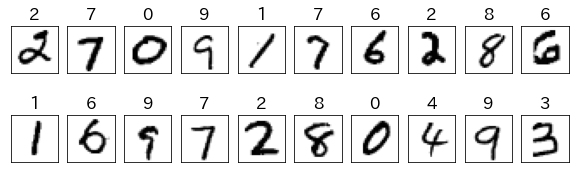

In [18]:
#イメージ表示
plt.figure(figsize=(10, 3))
for i in range(20):
  ax = plt.subplot(2, 10, i+1)

  #numpyに変換
  image = images[i].numpy()
  label = labels[i]

  #imgの範囲を[0, 1]に戻す
  image2 = (image + 1)/2
  #イメージ表示
  plt.imshow(image2.reshape(28, 28), cmap='gray_r')
  ax.set_title(f'{label}')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [19]:
#モデル定義
n_input = image.shape[0]

#出力次元数
n_output = len(set(list(labels.data.numpy())))

#隠れ層のノード数
n_hidden = 128

#結果確認
print(n_input)
print(n_output)
print(n_hidden)

784
10
128


##隠れ層２層化

In [20]:
# モデルの定義
# 784入力10出力2隠れ層のニューラルネットワークモデル

class Net2(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()
        
        # 隠れ層1の定義 (隠れ層のノード数: n_hidden)
        self.l1 = nn.Linear(n_input, n_hidden)

        # 隠れ層2の定義 (隠れ層のノード数: n_hidden)
        self.l2 = nn.Linear(n_hidden, n_hidden)

        # 出力層の定義
        self.l3 = nn.Linear(n_hidden, n_output)

        # ReLU関数の定義
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.relu(x1)
        x3 = self.l2(x2)
        x4 = self.relu(x3)
        x5 = self.l3(x4)
        return x5

In [22]:
# 乱数の固定化
torch.manual_seed(123)
torch.cuda.manual_seed(123)

# 学習率
lr = 0.01

# モデルインスタンス生成
net = Net2(n_input, n_output, n_hidden).to(device)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 最適化関数: 勾配降下法
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

In [23]:
# モデルの概要表示

print(net)

Net2(
  (l1): Linear(in_features=784, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=128, bias=True)
  (l3): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU(inplace=True)
)


In [24]:
# モデルのサマリー表示

summary(net, (784,))

Layer (type:depth-idx)                   Output Shape              Param #
Net2                                     --                        --
├─Linear: 1-1                            [128]                     100,480
├─ReLU: 1-2                              [128]                     --
├─Linear: 1-3                            [128]                     16,512
├─ReLU: 1-4                              [128]                     --
├─Linear: 1-5                            [10]                      1,290
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
Total mult-adds (M): 14.99
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.47
Estimated Total Size (MB): 0.48

In [25]:
# DataLoaderから最初の1セットを取得する
for images, labels in test_loader:
    break

# 予測結果の取得
inputs = images.to(device)
labels = labels.to(device)

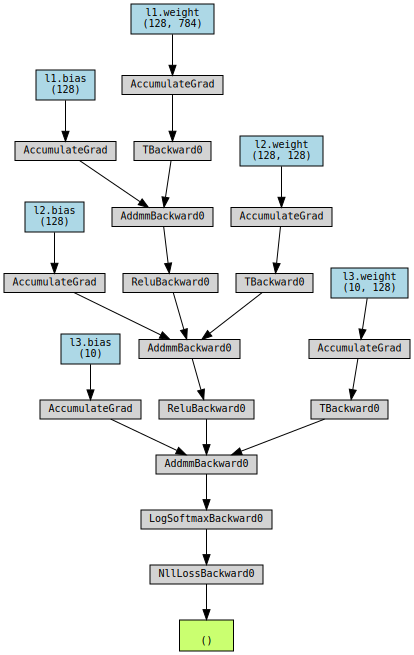

In [26]:

# 予測計算
outputs = net(inputs)

#  損失計算
loss = criterion(outputs, labels)

# 損失の計算グラフ可視化
make_dot(loss, params=dict(net.named_parameters()))

In [27]:
# 勾配計算
loss.backward()

# 勾配計算結果の一部
w = net.to('cpu').l1.weight.grad.numpy()
print(w)

# 各要素の絶対値の平均
print(np.abs(w).mean())

[[-0.00144 -0.00144 -0.00144 ... -0.00144 -0.00144 -0.00144]
 [-0.00035 -0.00035 -0.00035 ... -0.00035 -0.00035 -0.00035]
 [-0.00156 -0.00156 -0.00156 ... -0.00156 -0.00156 -0.00156]
 ...
 [ 0.00059  0.00059  0.00059 ...  0.00059  0.00059  0.00059]
 [-0.00085 -0.00085 -0.00085 ... -0.00085 -0.00085 -0.00085]
 [ 0.00008  0.00008  0.00008 ...  0.00008  0.00008  0.00008]]
0.00091555755


In [28]:
#繰り返し計算

# 乱数の固定化
torch.manual_seed(123)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True


# モデルインスタンス生成
net = Net2(n_input, n_output, n_hidden).to(device)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 最適化関数: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 繰り返し回数
num_epochs = 200

# 評価結果記録用
history2 = np.zeros((0,5))

In [30]:
# tqdmライブラリのインポート
from tqdm.notebook import tqdm


# 繰り返し計算メインループ
for epoch in range(num_epochs):
    train_acc = 0
    train_loss = 0
    val_acc = 0
    val_loss = 0
    n_train = 0
    n_test = 0

    # 訓練フェーズ
    for inputs, labels in tqdm(train_loader):
        n_train += len(labels)

        # GPUヘ転送
        inputs = inputs.to(device)
        labels = labels.to(device)
    
        #勾配の初期化
        optimizer.zero_grad()

        # 予測計算
        outputs = net(inputs)

        # 損失計算
        loss = criterion(outputs, labels)

        # 勾配計算
        loss.backward()
    
        # パラメータ修正
        optimizer.step()

        # 予測ラベル導出
        predicted = torch.max(outputs, 1)[1]

        # 損失と精度の計算
        train_loss += loss.item()
        train_acc += (predicted == labels).sum().item() 

    #予測フェーズ
    for inputs_test, labels_test in test_loader:
        n_test += len(labels_test)

        inputs_test = inputs_test.to(device)
        labels_test = labels_test.to(device)

        # 予測計算
        outputs_test = net(inputs_test)

        # 損失計算
        loss_test = criterion(outputs_test, labels_test)

        #予測ラベル導出
        predicted_test = torch.max(outputs_test, 1)[1]

        # 損失と精度の計算
        val_loss +=  loss_test.item()
        val_acc +=  (predicted_test == labels_test).sum().item()

    # 評価値の算出・記録
    train_acc = train_acc / n_train
    val_acc = val_acc / n_test
    train_loss = train_loss * batch_size / n_train
    val_loss = val_loss * batch_size / n_test
    print (f'Epoch [{epoch+1}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')
    item = np.array([epoch+1 , train_loss, train_acc, val_loss, val_acc])
    history2 = np.vstack((history2, item))


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [1/200], loss: 2.20163 acc: 0.25380 val_loss: 2.05003, val_acc: 0.49320


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [2/200], loss: 1.75820 acc: 0.60442 val_loss: 1.40628, val_acc: 0.68228


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [3/200], loss: 1.11285 acc: 0.75652 val_loss: 0.88087, val_acc: 0.80278


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [4/200], loss: 0.75172 acc: 0.82295 val_loss: 0.65093, val_acc: 0.83903


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [5/200], loss: 0.59030 acc: 0.84980 val_loss: 0.54002, val_acc: 0.86013


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [6/200], loss: 0.50672 acc: 0.86653 val_loss: 0.47956, val_acc: 0.86972


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [7/200], loss: 0.45680 acc: 0.87543 val_loss: 0.43690, val_acc: 0.87942


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [8/200], loss: 0.42335 acc: 0.88193 val_loss: 0.41060, val_acc: 0.88457


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [9/200], loss: 0.39965 acc: 0.88768 val_loss: 0.38970, val_acc: 0.88908


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [10/200], loss: 0.38195 acc: 0.89187 val_loss: 0.37331, val_acc: 0.89403


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [11/200], loss: 0.36793 acc: 0.89480 val_loss: 0.36185, val_acc: 0.89687


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [12/200], loss: 0.35633 acc: 0.89802 val_loss: 0.35052, val_acc: 0.89967


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [13/200], loss: 0.34649 acc: 0.89963 val_loss: 0.34065, val_acc: 0.90137


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [14/200], loss: 0.33814 acc: 0.90205 val_loss: 0.33294, val_acc: 0.90328


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [15/200], loss: 0.33042 acc: 0.90460 val_loss: 0.32906, val_acc: 0.90377


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [16/200], loss: 0.32383 acc: 0.90598 val_loss: 0.32070, val_acc: 0.90662


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [17/200], loss: 0.31778 acc: 0.90755 val_loss: 0.31474, val_acc: 0.90827


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [18/200], loss: 0.31207 acc: 0.90903 val_loss: 0.30979, val_acc: 0.90947


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [19/200], loss: 0.30686 acc: 0.91078 val_loss: 0.30341, val_acc: 0.91148


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [20/200], loss: 0.30214 acc: 0.91210 val_loss: 0.30002, val_acc: 0.91290


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [21/200], loss: 0.29754 acc: 0.91375 val_loss: 0.29428, val_acc: 0.91440


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [22/200], loss: 0.29329 acc: 0.91497 val_loss: 0.29005, val_acc: 0.91537


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [23/200], loss: 0.28879 acc: 0.91612 val_loss: 0.28666, val_acc: 0.91670


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [24/200], loss: 0.28527 acc: 0.91685 val_loss: 0.28229, val_acc: 0.91845


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [25/200], loss: 0.28131 acc: 0.91835 val_loss: 0.27815, val_acc: 0.91968


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [26/200], loss: 0.27773 acc: 0.91925 val_loss: 0.27458, val_acc: 0.92022


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [27/200], loss: 0.27412 acc: 0.92005 val_loss: 0.27236, val_acc: 0.92105


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [28/200], loss: 0.27082 acc: 0.92127 val_loss: 0.26898, val_acc: 0.92127


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [29/200], loss: 0.26761 acc: 0.92230 val_loss: 0.26629, val_acc: 0.92310


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [30/200], loss: 0.26485 acc: 0.92290 val_loss: 0.26279, val_acc: 0.92327


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [31/200], loss: 0.26136 acc: 0.92373 val_loss: 0.25902, val_acc: 0.92468


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [32/200], loss: 0.25844 acc: 0.92472 val_loss: 0.25580, val_acc: 0.92610


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [33/200], loss: 0.25553 acc: 0.92568 val_loss: 0.25370, val_acc: 0.92653


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [34/200], loss: 0.25281 acc: 0.92640 val_loss: 0.25018, val_acc: 0.92712


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [35/200], loss: 0.24961 acc: 0.92753 val_loss: 0.24755, val_acc: 0.92788


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [36/200], loss: 0.24678 acc: 0.92835 val_loss: 0.24696, val_acc: 0.92850


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [37/200], loss: 0.24412 acc: 0.92960 val_loss: 0.24268, val_acc: 0.92945


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [38/200], loss: 0.24160 acc: 0.93007 val_loss: 0.24041, val_acc: 0.92997


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [39/200], loss: 0.23888 acc: 0.93110 val_loss: 0.23612, val_acc: 0.93167


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [40/200], loss: 0.23618 acc: 0.93165 val_loss: 0.23384, val_acc: 0.93245


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [41/200], loss: 0.23375 acc: 0.93222 val_loss: 0.23077, val_acc: 0.93343


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [42/200], loss: 0.23097 acc: 0.93280 val_loss: 0.22910, val_acc: 0.93390


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [43/200], loss: 0.22850 acc: 0.93410 val_loss: 0.22664, val_acc: 0.93467


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [44/200], loss: 0.22613 acc: 0.93477 val_loss: 0.22371, val_acc: 0.93560


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [45/200], loss: 0.22345 acc: 0.93497 val_loss: 0.22086, val_acc: 0.93637


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [46/200], loss: 0.22104 acc: 0.93590 val_loss: 0.21905, val_acc: 0.93700


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [47/200], loss: 0.21873 acc: 0.93685 val_loss: 0.21666, val_acc: 0.93783


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [48/200], loss: 0.21633 acc: 0.93762 val_loss: 0.21492, val_acc: 0.93823


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [49/200], loss: 0.21397 acc: 0.93830 val_loss: 0.21248, val_acc: 0.93823


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [50/200], loss: 0.21180 acc: 0.93890 val_loss: 0.20929, val_acc: 0.93947


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [51/200], loss: 0.20945 acc: 0.93938 val_loss: 0.20796, val_acc: 0.94018


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [52/200], loss: 0.20722 acc: 0.94020 val_loss: 0.20796, val_acc: 0.93922


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [53/200], loss: 0.20505 acc: 0.94078 val_loss: 0.20250, val_acc: 0.94177


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [54/200], loss: 0.20264 acc: 0.94140 val_loss: 0.20093, val_acc: 0.94222


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [55/200], loss: 0.20042 acc: 0.94237 val_loss: 0.19846, val_acc: 0.94307


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [56/200], loss: 0.19844 acc: 0.94277 val_loss: 0.19658, val_acc: 0.94320


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [57/200], loss: 0.19652 acc: 0.94383 val_loss: 0.19410, val_acc: 0.94405


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [58/200], loss: 0.19422 acc: 0.94390 val_loss: 0.19234, val_acc: 0.94490


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [59/200], loss: 0.19227 acc: 0.94440 val_loss: 0.19042, val_acc: 0.94490


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [60/200], loss: 0.19031 acc: 0.94535 val_loss: 0.18821, val_acc: 0.94582


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [61/200], loss: 0.18842 acc: 0.94567 val_loss: 0.18622, val_acc: 0.94640


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [62/200], loss: 0.18623 acc: 0.94680 val_loss: 0.18472, val_acc: 0.94667


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [63/200], loss: 0.18459 acc: 0.94675 val_loss: 0.18276, val_acc: 0.94727


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [64/200], loss: 0.18266 acc: 0.94697 val_loss: 0.18116, val_acc: 0.94778


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [65/200], loss: 0.18071 acc: 0.94810 val_loss: 0.17885, val_acc: 0.94853


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [66/200], loss: 0.17905 acc: 0.94832 val_loss: 0.17685, val_acc: 0.94915


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [67/200], loss: 0.17725 acc: 0.94930 val_loss: 0.17578, val_acc: 0.94915


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [68/200], loss: 0.17530 acc: 0.94980 val_loss: 0.17331, val_acc: 0.95027


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [69/200], loss: 0.17379 acc: 0.94985 val_loss: 0.17154, val_acc: 0.95062


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [70/200], loss: 0.17195 acc: 0.95058 val_loss: 0.17012, val_acc: 0.95130


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [71/200], loss: 0.17031 acc: 0.95120 val_loss: 0.16818, val_acc: 0.95157


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [72/200], loss: 0.16848 acc: 0.95133 val_loss: 0.16657, val_acc: 0.95233


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [73/200], loss: 0.16689 acc: 0.95193 val_loss: 0.16515, val_acc: 0.95270


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [74/200], loss: 0.16519 acc: 0.95255 val_loss: 0.16459, val_acc: 0.95228


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [75/200], loss: 0.16374 acc: 0.95278 val_loss: 0.16246, val_acc: 0.95350


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [76/200], loss: 0.16228 acc: 0.95352 val_loss: 0.16066, val_acc: 0.95385


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [77/200], loss: 0.16059 acc: 0.95378 val_loss: 0.15976, val_acc: 0.95378


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [78/200], loss: 0.15917 acc: 0.95420 val_loss: 0.15744, val_acc: 0.95500


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [79/200], loss: 0.15768 acc: 0.95462 val_loss: 0.15617, val_acc: 0.95550


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [80/200], loss: 0.15608 acc: 0.95530 val_loss: 0.15421, val_acc: 0.95578


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [81/200], loss: 0.15466 acc: 0.95567 val_loss: 0.15294, val_acc: 0.95617


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [82/200], loss: 0.15333 acc: 0.95597 val_loss: 0.15173, val_acc: 0.95640


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [83/200], loss: 0.15187 acc: 0.95638 val_loss: 0.15022, val_acc: 0.95693


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [84/200], loss: 0.15063 acc: 0.95690 val_loss: 0.14895, val_acc: 0.95732


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [85/200], loss: 0.14917 acc: 0.95710 val_loss: 0.14828, val_acc: 0.95792


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [86/200], loss: 0.14784 acc: 0.95780 val_loss: 0.14599, val_acc: 0.95808


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [87/200], loss: 0.14651 acc: 0.95782 val_loss: 0.14468, val_acc: 0.95840


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [88/200], loss: 0.14520 acc: 0.95833 val_loss: 0.14338, val_acc: 0.95892


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [89/200], loss: 0.14406 acc: 0.95880 val_loss: 0.14227, val_acc: 0.95938


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [90/200], loss: 0.14250 acc: 0.95922 val_loss: 0.14172, val_acc: 0.95918


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [91/200], loss: 0.14149 acc: 0.95975 val_loss: 0.13967, val_acc: 0.96008


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [92/200], loss: 0.14012 acc: 0.95967 val_loss: 0.13950, val_acc: 0.96030


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [93/200], loss: 0.13899 acc: 0.96013 val_loss: 0.13878, val_acc: 0.96005


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [94/200], loss: 0.13764 acc: 0.96063 val_loss: 0.13702, val_acc: 0.96047


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [95/200], loss: 0.13661 acc: 0.96095 val_loss: 0.13598, val_acc: 0.96085


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [96/200], loss: 0.13548 acc: 0.96135 val_loss: 0.13463, val_acc: 0.96162


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [97/200], loss: 0.13419 acc: 0.96173 val_loss: 0.13276, val_acc: 0.96203


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [98/200], loss: 0.13311 acc: 0.96218 val_loss: 0.13233, val_acc: 0.96193


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [99/200], loss: 0.13192 acc: 0.96233 val_loss: 0.13031, val_acc: 0.96322


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [100/200], loss: 0.13092 acc: 0.96293 val_loss: 0.12928, val_acc: 0.96313


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [101/200], loss: 0.12981 acc: 0.96282 val_loss: 0.12827, val_acc: 0.96382


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [102/200], loss: 0.12866 acc: 0.96337 val_loss: 0.12745, val_acc: 0.96388


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [103/200], loss: 0.12769 acc: 0.96383 val_loss: 0.12616, val_acc: 0.96413


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [104/200], loss: 0.12656 acc: 0.96403 val_loss: 0.12511, val_acc: 0.96475


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [105/200], loss: 0.12554 acc: 0.96418 val_loss: 0.12448, val_acc: 0.96448


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [106/200], loss: 0.12453 acc: 0.96453 val_loss: 0.12316, val_acc: 0.96517


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [107/200], loss: 0.12354 acc: 0.96493 val_loss: 0.12184, val_acc: 0.96568


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [108/200], loss: 0.12244 acc: 0.96552 val_loss: 0.12078, val_acc: 0.96580


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [109/200], loss: 0.12136 acc: 0.96558 val_loss: 0.12054, val_acc: 0.96602


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [110/200], loss: 0.12065 acc: 0.96585 val_loss: 0.11894, val_acc: 0.96617


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [111/200], loss: 0.11937 acc: 0.96615 val_loss: 0.11824, val_acc: 0.96657


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [112/200], loss: 0.11857 acc: 0.96643 val_loss: 0.11716, val_acc: 0.96693


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [113/200], loss: 0.11759 acc: 0.96645 val_loss: 0.11611, val_acc: 0.96703


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [114/200], loss: 0.11657 acc: 0.96680 val_loss: 0.11504, val_acc: 0.96742


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [115/200], loss: 0.11586 acc: 0.96743 val_loss: 0.11441, val_acc: 0.96763


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [116/200], loss: 0.11487 acc: 0.96710 val_loss: 0.11333, val_acc: 0.96790


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [117/200], loss: 0.11384 acc: 0.96792 val_loss: 0.11234, val_acc: 0.96835


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [118/200], loss: 0.11302 acc: 0.96762 val_loss: 0.11190, val_acc: 0.96858


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [119/200], loss: 0.11220 acc: 0.96833 val_loss: 0.11050, val_acc: 0.96855


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [120/200], loss: 0.11139 acc: 0.96838 val_loss: 0.10984, val_acc: 0.96907


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [121/200], loss: 0.11043 acc: 0.96862 val_loss: 0.10987, val_acc: 0.96902


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [122/200], loss: 0.10965 acc: 0.96890 val_loss: 0.10819, val_acc: 0.96927


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [123/200], loss: 0.10866 acc: 0.96920 val_loss: 0.10762, val_acc: 0.96970


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [124/200], loss: 0.10766 acc: 0.96990 val_loss: 0.10672, val_acc: 0.96977


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [125/200], loss: 0.10707 acc: 0.96985 val_loss: 0.10554, val_acc: 0.97005


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [126/200], loss: 0.10626 acc: 0.96998 val_loss: 0.10525, val_acc: 0.97018


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [127/200], loss: 0.10538 acc: 0.97010 val_loss: 0.10414, val_acc: 0.97065


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [128/200], loss: 0.10458 acc: 0.97063 val_loss: 0.10346, val_acc: 0.97062


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [129/200], loss: 0.10393 acc: 0.97052 val_loss: 0.10296, val_acc: 0.97093


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [130/200], loss: 0.10300 acc: 0.97113 val_loss: 0.10168, val_acc: 0.97138


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [131/200], loss: 0.10221 acc: 0.97097 val_loss: 0.10091, val_acc: 0.97157


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [132/200], loss: 0.10160 acc: 0.97127 val_loss: 0.10179, val_acc: 0.97128


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [133/200], loss: 0.10085 acc: 0.97152 val_loss: 0.10028, val_acc: 0.97172


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [134/200], loss: 0.10005 acc: 0.97187 val_loss: 0.09899, val_acc: 0.97228


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [135/200], loss: 0.09922 acc: 0.97222 val_loss: 0.09858, val_acc: 0.97227


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [136/200], loss: 0.09863 acc: 0.97228 val_loss: 0.09776, val_acc: 0.97267


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [137/200], loss: 0.09798 acc: 0.97233 val_loss: 0.09659, val_acc: 0.97280


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [138/200], loss: 0.09722 acc: 0.97275 val_loss: 0.09661, val_acc: 0.97320


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [139/200], loss: 0.09644 acc: 0.97285 val_loss: 0.09607, val_acc: 0.97302


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [140/200], loss: 0.09575 acc: 0.97332 val_loss: 0.09448, val_acc: 0.97400


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [141/200], loss: 0.09501 acc: 0.97352 val_loss: 0.09395, val_acc: 0.97383


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [142/200], loss: 0.09444 acc: 0.97367 val_loss: 0.09305, val_acc: 0.97422


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [143/200], loss: 0.09380 acc: 0.97378 val_loss: 0.09233, val_acc: 0.97408


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [144/200], loss: 0.09305 acc: 0.97375 val_loss: 0.09201, val_acc: 0.97452


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [145/200], loss: 0.09243 acc: 0.97435 val_loss: 0.09180, val_acc: 0.97440


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [146/200], loss: 0.09180 acc: 0.97437 val_loss: 0.09033, val_acc: 0.97473


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [147/200], loss: 0.09103 acc: 0.97472 val_loss: 0.09043, val_acc: 0.97467


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [148/200], loss: 0.09046 acc: 0.97485 val_loss: 0.08929, val_acc: 0.97492


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [149/200], loss: 0.08975 acc: 0.97487 val_loss: 0.08860, val_acc: 0.97548


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [150/200], loss: 0.08934 acc: 0.97522 val_loss: 0.08803, val_acc: 0.97550


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [151/200], loss: 0.08858 acc: 0.97525 val_loss: 0.08740, val_acc: 0.97582


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [152/200], loss: 0.08806 acc: 0.97560 val_loss: 0.08682, val_acc: 0.97588


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [153/200], loss: 0.08736 acc: 0.97570 val_loss: 0.08691, val_acc: 0.97578


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [154/200], loss: 0.08676 acc: 0.97603 val_loss: 0.08641, val_acc: 0.97567


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [155/200], loss: 0.08624 acc: 0.97612 val_loss: 0.08540, val_acc: 0.97638


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [156/200], loss: 0.08569 acc: 0.97610 val_loss: 0.08504, val_acc: 0.97632


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [157/200], loss: 0.08511 acc: 0.97642 val_loss: 0.08406, val_acc: 0.97682


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [158/200], loss: 0.08447 acc: 0.97680 val_loss: 0.08344, val_acc: 0.97663


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [159/200], loss: 0.08406 acc: 0.97655 val_loss: 0.08345, val_acc: 0.97675


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [160/200], loss: 0.08338 acc: 0.97658 val_loss: 0.08236, val_acc: 0.97728


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [161/200], loss: 0.08283 acc: 0.97675 val_loss: 0.08153, val_acc: 0.97737


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [162/200], loss: 0.08240 acc: 0.97692 val_loss: 0.08104, val_acc: 0.97745


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [163/200], loss: 0.08169 acc: 0.97737 val_loss: 0.08041, val_acc: 0.97768


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [164/200], loss: 0.08130 acc: 0.97728 val_loss: 0.07996, val_acc: 0.97780


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [165/200], loss: 0.08049 acc: 0.97785 val_loss: 0.07931, val_acc: 0.97777


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [166/200], loss: 0.08013 acc: 0.97767 val_loss: 0.07905, val_acc: 0.97835


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [167/200], loss: 0.07953 acc: 0.97785 val_loss: 0.07825, val_acc: 0.97847


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [168/200], loss: 0.07903 acc: 0.97825 val_loss: 0.07804, val_acc: 0.97848


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [169/200], loss: 0.07872 acc: 0.97817 val_loss: 0.07742, val_acc: 0.97883


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [170/200], loss: 0.07799 acc: 0.97813 val_loss: 0.07704, val_acc: 0.97852


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [171/200], loss: 0.07756 acc: 0.97840 val_loss: 0.07741, val_acc: 0.97845


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [172/200], loss: 0.07695 acc: 0.97892 val_loss: 0.07581, val_acc: 0.97903


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [173/200], loss: 0.07657 acc: 0.97895 val_loss: 0.07584, val_acc: 0.97895


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [174/200], loss: 0.07594 acc: 0.97898 val_loss: 0.07524, val_acc: 0.97910


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [175/200], loss: 0.07563 acc: 0.97905 val_loss: 0.07425, val_acc: 0.97942


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [176/200], loss: 0.07505 acc: 0.97933 val_loss: 0.07454, val_acc: 0.97948


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [177/200], loss: 0.07464 acc: 0.97928 val_loss: 0.07426, val_acc: 0.97915


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [178/200], loss: 0.07402 acc: 0.97928 val_loss: 0.07316, val_acc: 0.97983


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [179/200], loss: 0.07367 acc: 0.97963 val_loss: 0.07293, val_acc: 0.98015


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [180/200], loss: 0.07328 acc: 0.97952 val_loss: 0.07226, val_acc: 0.98000


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [181/200], loss: 0.07270 acc: 0.97985 val_loss: 0.07169, val_acc: 0.97992


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [182/200], loss: 0.07232 acc: 0.97995 val_loss: 0.07150, val_acc: 0.98033


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [183/200], loss: 0.07192 acc: 0.98008 val_loss: 0.07127, val_acc: 0.98033


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [184/200], loss: 0.07139 acc: 0.98013 val_loss: 0.07025, val_acc: 0.98057


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [185/200], loss: 0.07089 acc: 0.98027 val_loss: 0.07029, val_acc: 0.98068


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [186/200], loss: 0.07047 acc: 0.98057 val_loss: 0.06945, val_acc: 0.98103


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [187/200], loss: 0.06993 acc: 0.98050 val_loss: 0.06970, val_acc: 0.98075


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [188/200], loss: 0.06970 acc: 0.98093 val_loss: 0.06850, val_acc: 0.98110


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [189/200], loss: 0.06914 acc: 0.98090 val_loss: 0.06848, val_acc: 0.98108


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [190/200], loss: 0.06889 acc: 0.98112 val_loss: 0.06775, val_acc: 0.98168


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [191/200], loss: 0.06827 acc: 0.98115 val_loss: 0.06750, val_acc: 0.98143


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [192/200], loss: 0.06802 acc: 0.98118 val_loss: 0.06834, val_acc: 0.98097


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [193/200], loss: 0.06756 acc: 0.98155 val_loss: 0.06695, val_acc: 0.98170


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [194/200], loss: 0.06716 acc: 0.98163 val_loss: 0.06594, val_acc: 0.98220


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [195/200], loss: 0.06655 acc: 0.98178 val_loss: 0.06689, val_acc: 0.98147


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [196/200], loss: 0.06636 acc: 0.98177 val_loss: 0.06537, val_acc: 0.98238


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [197/200], loss: 0.06592 acc: 0.98215 val_loss: 0.06509, val_acc: 0.98218


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [198/200], loss: 0.06555 acc: 0.98200 val_loss: 0.06517, val_acc: 0.98218


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [199/200], loss: 0.06517 acc: 0.98213 val_loss: 0.06395, val_acc: 0.98253


  0%|          | 0/120 [00:00<?, ?it/s]

Epoch [200/200], loss: 0.06462 acc: 0.98258 val_loss: 0.06419, val_acc: 0.98257


In [31]:
#損失と精度の確認

print(f'初期状態: 損失: {history2[0,3]:.5f} 精度: {history2[0,4]:.5f}' )
print(f'最終状態: 損失: {history2[-1,3]:.5f} 精度: {history2[-1,4]:.5f}' )

初期状態: 損失: 2.05003 精度: 0.49320
最終状態: 損失: 0.06419 精度: 0.98257


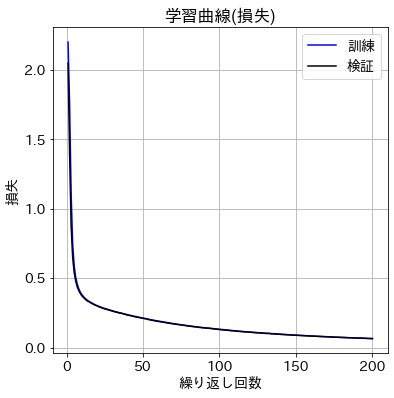

In [32]:
# 学習曲線の表示 (損失)
plt.plot(history2[:,0], history2[:,1], 'b', label='訓練')
plt.plot(history2[:,0], history2[:,3], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('損失')
plt.title('学習曲線(損失)')
plt.legend()
plt.show()

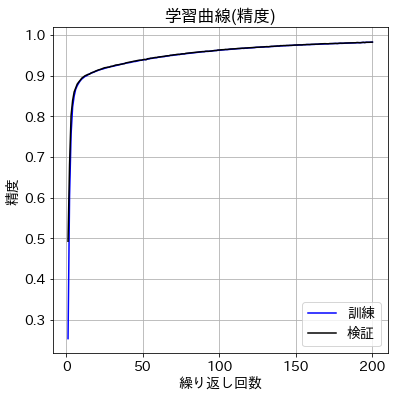

In [33]:
# 学習曲線の表示 (精度)

plt.plot(history2[:,0], history2[:,2], 'b', label='訓練')
plt.plot(history2[:,0], history2[:,4], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('精度')
plt.title('学習曲線(精度)')
plt.legend()
plt.show()


In [34]:
#イメージで確認
#DataLoaderから最初に１セットを取得する
for images, labels in test_loader:
  break

#予測結果の取得
inputs = images.to(device)
labels = labels.to(device)
outputs = net(inputs)
predicted = torch.max(outputs, 1)[1]

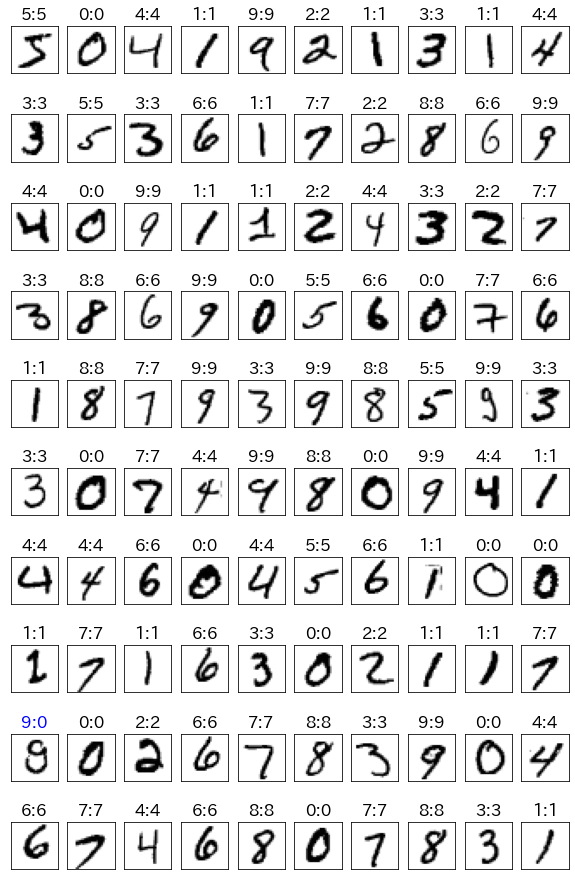

In [35]:
#最初の100件でイメージを「正解値:予測値」と表示

plt.figure(figsize=(10,16))
for i in range(100):
  ax = plt.subplot(10, 10, i+1)

  #numpyに変換
  image = images[i]
  label = labels[i]
  pred = predicted[i]
  if (pred == label):
    c='k'
  else:
    c='b'

  #imgの範囲を[0, 1]に戻す
  image2 = (image + 1)/2

  #イメージ表示
  plt.imshow(image2.reshape(28, 28), cmap='gray_r')
  ax.set_title(f'{label}:{pred}', c=c)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()